# 17.3 Metryki 

## Poniżej powtórka z zadania 17.2 z którego będą liczone metryki

#### Import niezbednych bibliotek i paczek

In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

#### Definicje wszystkich funkcji

In [2]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
def tokenize(text):
    # Usunięcie wielkich liter
    clean_text = text.lower()
    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words

#### Import pliku z danymi i jego formatowanie

In [3]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],
                           skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])

C:\Users\piotr\AppData\Local\Temp\ipykernel_27056\1552169415.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])


#### Obróbka danych - czyszczenie, tokenizacja, usuwanie stop words, Stemming, Lametyzcja

In [4]:
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))
spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))
stopwords = nltk.corpus.stopwords.words("english")
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))
stemmer = nltk.PorterStemmer()
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))
lemmater = nltk.WordNetLemmatizer()
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))

#### Rozdzielenie na X, y

In [5]:
X = spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x))
y = spam_dataset['Spam']

#### Rozdzielenie danych na zbiory treningowe oraz testowe

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Wektoryzacja TF-IDF

#### Wykonanie wektoryzacji TfidfVectorizer dla danych testowych i treningowych, następnie wyszkolenie nmmodelu RandomForestClassifier dla X treningowych i odczytwanie wyniku

In [7]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
clf_tfidf = RandomForestClassifier()
clf_tfidf.fit(X_train_tfidf, y_train)
print("Wartość Score dla RandomForestCalssifier, przy TfidfVectorizer:",clf_tfidf.score(X_test_tfidf, y_test))

Wartość Score dla RandomForestCalssifier, przy TfidfVectorizer: 0.9766816143497757


#### Określenie indeksu słów które miały ważność większą niż 0.001 dla RandomForestClassifier, a następnie przekazanie do dalszej analizy matryc zawierających tylko te najważniejsze słowa, zarówno dla danych treningowych jak i testowych

In [8]:
important_features = (np.where(clf_tfidf.feature_importances_ > 0.001))[0].tolist()
X_train_imp = X_train_tfidf[:,important_features]
X_test_imp = X_test_tfidf[:,important_features]

#### Wyszkolenie nowego RandomForestClassifier z wykorzystaniem Grid Search dla słów z ważnością wiekszą niż 0.001, odczytanie wyniku

In [9]:
random_forest = RandomForestClassifier( n_jobs=-1)
params_rf = {'max_depth': [ None, 15],
             'min_samples_leaf': [1, 3],
             'n_estimators': [ 50, 100, 150 ],
             'min_samples_split': [2, 3, 5]}

rf_gridsearch = GridSearchCV(random_forest,
                             params_rf,
                             scoring='f1_micro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch.fit(X_train_imp, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
model_tfidf = rf_gridsearch.best_estimator_
model_tfidf.fit(X_train_imp, y_train)
print("Grid search for RandomForestClassifier Score Test (TfidfVectorizer):", model_tfidf.score(X_test_imp, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best hyperparameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Grid search for RandomForestClassifier Score Test (TfidfVectorizer): 0.9802690582959641


## Wektoryzacja CountVectorizer - metodologia taka sama jak poprzednio

In [10]:
count = CountVectorizer()
X_train_count = count.fit_transform(X_train)
X_test_count = count.transform(X_test)
clf_count = RandomForestClassifier()
clf_count.fit(X_train_count, y_train)
print("Wartość Score dla RandomForestCalssifier, przy CountVectorizer:",clf_count.score(X_test_count, y_test))

Wartość Score dla RandomForestCalssifier, przy CountVectorizer: 0.9730941704035875


In [11]:
important_features_count = (np.where(clf_count.feature_importances_ > 0.001))[0].tolist()
X_train_imp_count = X_train_count[:,important_features_count]
X_test_imp_count = X_test_count[:,important_features_count]

In [12]:
random_forest = RandomForestClassifier( n_jobs=-1)
params_rf = {'max_depth': [ None, 15 ],
             'min_samples_leaf': [1, 3],
             'n_estimators': [ 50, 100, 150 ],
             'min_samples_split': [2, 3, 5]}

rf_gridsearch = GridSearchCV(random_forest,
                             params_rf,
                             scoring='f1_micro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch.fit(X_train_imp_count, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
model_count = rf_gridsearch.best_estimator_
model_count.fit(X_train_imp_count, y_train)
print("Grid search for RandomForestClassifier Score Test (CountVectorizer):", model_count.score(X_test_imp_count, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best hyperparameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Grid search for RandomForestClassifier Score Test (CountVectorizer): 0.9775784753363229


#### Dzięki użyciu słow które miały wazność wiekszą niż 0.001 (dla pierwszego użycia RandomForestClassifier) Udało się poprwić wynik Score klasyfikacji  RandomForestClassifier zarowno dla  CountVectorizer jak i dla TfidfVectorizer

# Zadanie 17.3 Cześć Właściwa

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Raport z klasyfikacji dla Random Forest Classification przy TfidfVectorizer i grid search oraz confusion matrix

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



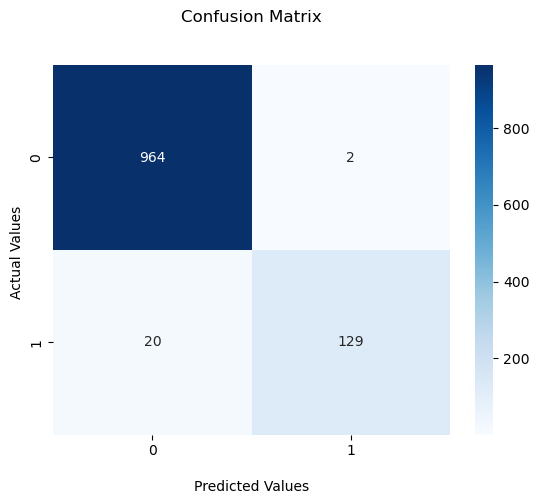

In [14]:
print(classification_report(y_test, model_tfidf.predict(X_test_imp)))
plt.figure()
cm = confusion_matrix(y_test, model_tfidf.predict(X_test_imp))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

## Raport z klasyfikacji dla Random Forest Classification przy CountVectorizer i grid search oraz confusion matrix

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



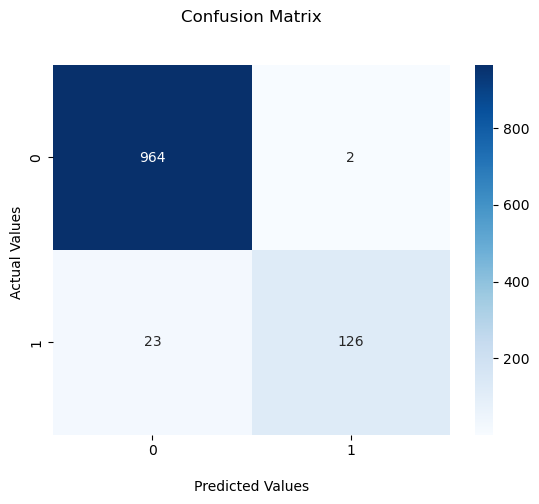

In [15]:
print(classification_report(y_test, model_count.predict(X_test_imp_count)))
plt.figure()
cm = confusion_matrix(y_test, model_count.predict(X_test_imp_count))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()